# Titanic: Machine Learning from Disaster

In [ ]:
# https://www.kaggle.com/c/titanic

In [1]:
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_dummies = pd.get_dummies(train, columns=['Sex', 'Pclass', 'Embarked'])
test_dummies = pd.get_dummies(test, columns=['Sex', 'Pclass', 'Embarked'])
combined = [train_dummies, test_dummies]
# Добавим признаки Размер семьи и путешествовал ли человек один
for dataset in combined:   
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone']  = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

## Preprocess data

In [5]:
# Extract features
X_train = train_dummies.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X_test = test_dummies.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [6]:
# Extract targets
y_train = train_dummies['Survived']

In [7]:
# Fill NA values
from sklearn.preprocessing import Imputer
imp = Imputer()
imp.fit(X_train)
X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)
# Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

In [8]:
# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# StandardScaler(copy=True, with_mean=True, with_std=True)

## Train model and make predictions

In [9]:
# Fit logistic regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(class_weight='balanced', random_state=123)

param_grid = [{'max_depth': range(1,12), 'min_samples_split': range(2,10), 'min_samples_leaf': range(1,6)}]

grid = GridSearchCV(clf, param_grid, cv=5)

In [10]:
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_depth': range(1, 12), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 6)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [11]:
FI = list(zip( X_train.columns,grid.best_estimator_.feature_importances_))

In [12]:
FI.sort(key=lambda x: x[1], reverse=True)

In [13]:
x_labels = [val[0] for val in FI]
y_labels = [val[1] for val in FI]

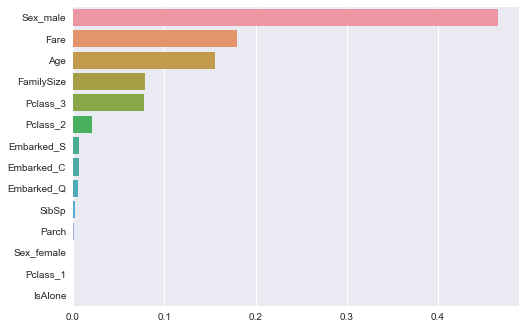

In [14]:
sns.barplot( y_labels, x_labels, orient='h')

Сильнее всего определить "выживаемость" пассажира помогают его пол, возраст и размер платы за проезд.

In [15]:
# TODO: make predictions

predicted = grid.best_estimator_.predict(X_test_scaled)

In [ ]:
with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted):
        out.write('%s,%s\n' % (passenger, y))

## Рисуем дерево

In [16]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [17]:
get_tree_dot_view(grid.best_estimator_, X_train.columns, ['Не выжил','Выжил'])

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="Sex_male <= -0.3089\ngini = 0.5\nsamples = 891\nvalue = [445.5, 445.5]\nclass = Не выжил", fillcolor="#e5813900"] ;
1 [label="Pclass_3 <= -0.1027\ngini = 0.2926\nsamples = 314\nvalue = [65.7295, 303.5132]\nclass = Выжил", fillcolor="#399de5c8"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Fare <= -0.0674\ngini = 0.065\nsamples = 170\nvalue = [7.3033, 209.7237]\nclass = Выжил", fillcolor="#399de5f6"] ;
1 -> 2 ;
3 [label="Age <= 0.5618\ngini = 0.1211\nsamples = 70\nvalue = [5.6803, 82.0658]\nclass = Выжил", fillcolor="#399de5ed"] ;
2 -> 3 ;
4 [label="Age <= -0.1692\ngini = 0.0736\nsamples = 50\nvalue = [2.4344, 61.2237]\nclass = Выжил", fillcolor="#399de5f5"] ;
3 -> 4 ;
5 [label="Age <= -0.3231\ngini = 0.139\nsamples = 26\nvalue = [2.4344, 29.9605]\nclass = Выжил", fillcolor="#399de5ea"] ;
4 -> 5 ;
6 [label="Fare <= -0.3787\ngini = 0.056\nsamples = 22\nvalue = [0.8115, 27.3553]\nclass 